In [6]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib qt

In [7]:
test_id=3

In [8]:
y = glob('./original/*')
x = glob('./groundtruth/*')
y, x

(['./original\\CT_001.bmp',
  './original\\CT_002.bmp',
  './original\\CT_003.bmp',
  './original\\CT_004.bmp'],
 ['./groundtruth\\Ground_Truth_CT_001.bmp',
  './groundtruth\\Ground_Truth_CT_002.bmp',
  './groundtruth\\Ground_Truth_CT_003.bmp',
  './groundtruth\\Ground_Truth_CT_004.bmp'])

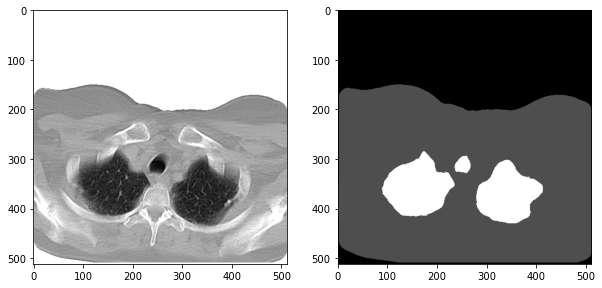

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(plt.imread(y[0]), cmap='gray')
axes[1].imshow(plt.imread(x[0]), cmap='gray')

In [10]:
np.unique(plt.imread(x[0]))


array([  0,  78, 245, 246, 247, 248, 249, 251, 252, 253, 254, 255],
      dtype=uint8)

In [11]:
def calc_vars(y, x):
    lung = y[x > 100]
    chest = y[(x > 0) & (x < 100)]

    lung_vars = lung.mean(), lung.var(), lung.size/(lung.size+chest.size)
    chest_vars = chest.mean(), chest.var(), chest.size/(lung.size+chest.size)
    return lung_vars, chest_vars

In [12]:
# train function with leave one out method
def train(test_id):
    paths = list(zip(y, x))
    del paths[test_id]

    lung_vars = []
    chest_vars = []

    for y_pth, x_pth in paths:
        y_img, x_img = plt.imread(y_pth), plt.imread(x_pth)
        img_lung_vars, img_chest_var = calc_vars(y_img, x_img)
        lung_vars.append(img_lung_vars)
        chest_vars.append(img_chest_var)
        
    global lung_mean, lung_var, p_lung, chest_mean, chest_var, p_chest

    lung_mean, lung_var, p_lung= np.array(lung_vars).mean(0)
    chest_mean, chest_var, p_chest = np.array(chest_vars).mean(0)


In [13]:
train(test_id)
(lung_mean, lung_var, p_lung), (chest_mean, chest_var, p_chest)

((49.24039597258638, 537.8482690781166, 0.2617549855655486),
 (167.19419418432005, 833.7076418804464, 0.7382450144344513))

In [14]:
pl = lambda q: p_lung*np.exp(-((q-lung_mean)**2)/(2*lung_var)) / np.sqrt(2*np.pi*lung_var)
pc = lambda q: p_chest*np.exp(-((q-chest_mean)**2)/(2*chest_var)) / np.sqrt(2*np.pi*chest_var)
compare = lambda q : pl(q)>=pc(q)

In [15]:
def segment(img):
    lung_mask = compare(img) # binary image of the lung
    lung_image = lung_mask*img # element wise multiplication to get the greyscale image of the lung
    chest_image = ~lung_mask*img # invert the binary image to get the chest

    return lung_image, chest_image

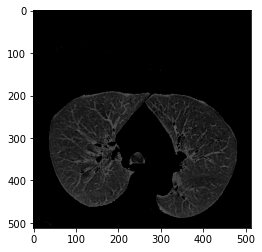

In [24]:
plt.imshow(compare(plt.imread(y[test_id]))*plt.imread(y[test_id]),cmap='gray',vmax=255)

In [16]:
test_y=plt.imread(y[test_id])
test_x=plt.imread(x[test_id])
lung_image,chest_image = segment(test_y)

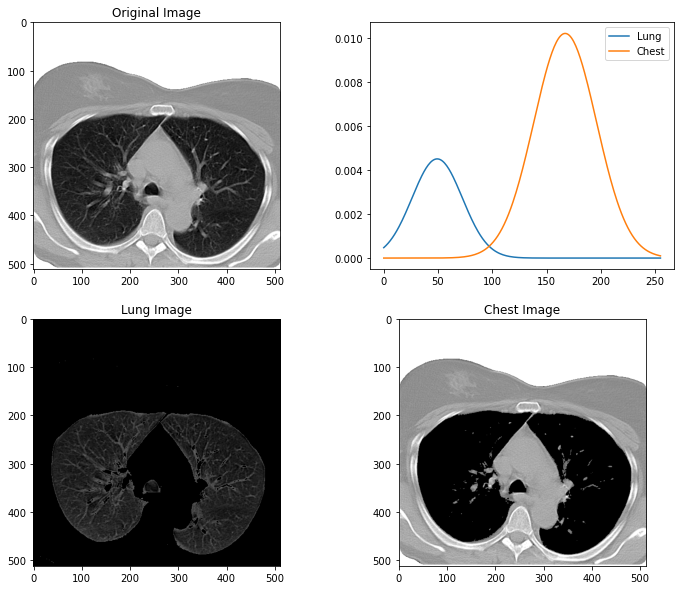

In [12]:
def show():
    fig,axes=plt.subplots(2,2,figsize=(12,10))

    axes[0,0].imshow(test_y,cmap='gray', vmin=0, vmax=255)
    axes[0,0].set(title='Original Image')

    q = range(256)
    axes[0,1].plot(q,pl(q),label='Lung')
    axes[0,1].plot(q,pc(q),label='Chest')
    axes[0,1].legend()

    axes[1,0].imshow(lung_image,cmap='gray', vmin=0, vmax=255)
    axes[1,0].set(title='Lung Image')

    axes[1,1].imshow(chest_image,cmap='gray', vmin=0, vmax=255)
    axes[1,1].set(title='Chest Image')

show()

In [26]:
compare(plt.imread(y[test_id])).flatten()

array([False, False, False, ..., False, False, False])

In [32]:
(plt.imread(x[test_id])>100).flatten()

array([False, False, False, ..., False, False, False])

In [13]:
def DSC(y_img,x_img):
    y = compare(y_img).flatten()
    x = (x_img>100).flatten()
    tp = (x * y).sum()
    fp = (~x * y).sum()
    fn = (x * ~y).sum()
    return 2*tp/(2*tp+fn+fp)

def test(test_id):
    test_y = plt.imread(y[test_id])
    test_x = plt.imread(x[test_id])
    return DSC(test_y,test_x)
    

In [14]:
print(f'DSC = {test(test_id)}')

DSC = 0.9616652874148577


# Validation

In [15]:
DSCs=np.zeros(len(y))
for i in range(len(y)):
    train(i)
    DSCs[i]=test(i)
    print(f'Training the model and testing on image({i}) --> DSC = {DSCs[i]}')

Training the model and testing on image(0) --> DSC = 0.9426248258365046
Training the model and testing on image(1) --> DSC = 0.9742403208391177
Training the model and testing on image(2) --> DSC = 0.9560583071011769
Training the model and testing on image(3) --> DSC = 0.9616652874148577


In [16]:
DSCs.mean()

0.9586471852979143

Accepted

DSC = 0.9742403208391177


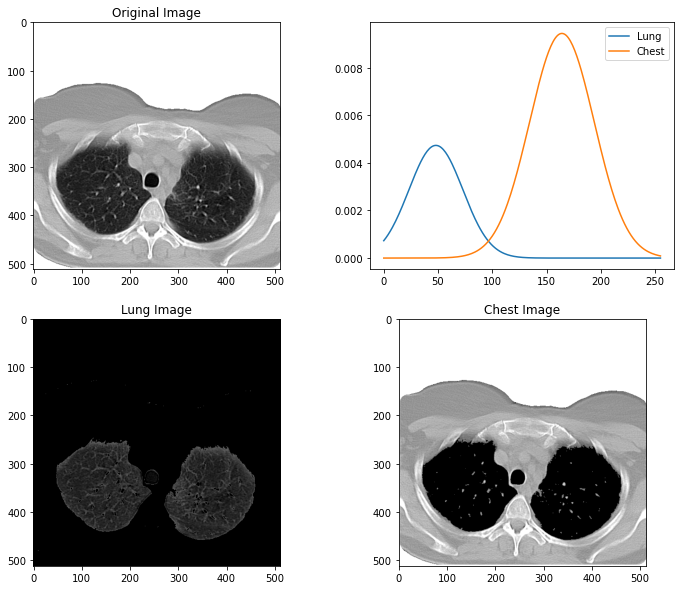

In [17]:
# training for the best DSC
test_id=DSCs.argmax()
train(test_id)
test_y=plt.imread(y[test_id])
test_x=plt.imread(x[test_id])
lung_image,chest_image = segment(test_y)
show()
print(f'DSC = {test(test_id)}')


# Final model parameters

In [18]:
(lung_mean, lung_var, p_lung)

(48.05384337837438, 617.538061718146, 0.2950886382501044)

In [19]:
(chest_mean, chest_var, p_chest)

(164.1760943484364, 886.4373431684157, 0.7049113617498955)

In [52]:
(True)

True